# Candy Pick Demo with AWS Sagemaker

Here is the system architecture for this demo:
![system architecture](./AWS_MiniBOT_Pick_Jupyter.png)

### improvement:  
Calibrate camera distortion by aruco marker  
Calibrate robot arm homing parameter

### 1. Import lib for AWS sagemaker

In [1]:
## Impport necessary library
%matplotlib inline

import os
import random

import base64
import time

import numpy as np
import matplotlib.pyplot as plt

import boto3
import botocore
import sagemaker
#from urllib.parse import urlparse
from urlparse import urlparse

import aws_setting # save all my aws related (sensitive) parameter in here

BUCKET = aws_setting.BUCKET #
#EXP_NAME = aws_setting.EXP_NAME #
job_name = aws_setting.job_name #

# Make sure the bucket is in the same region as this notebook.
role = aws_setting.role # 
region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)
sagemaker_client = boto3.client('sagemaker')
print sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

# Create a sagemaker-runtime client for inference
sagemaker_client = boto3.client('sagemaker-runtime')

# the name of infernce endpoint that host in AWS SageMaker
endpoint_name = aws_setting.endpoint_name #

Completed


### 1.1 Import ipywidget to create simple interactive UI
[Reference](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html)

In [2]:
import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import HBox, VBox

## 2. Import lib for MiniBOT (control robot arm)

In [3]:
%config IPCompleter.greedy=True
import sys
sys.path.append("C://Users/MiniBot/Documents/NexMotion-Python_API/")
import nexmotion as nm
from nexmotion.errors import *
from nexmotion.constants import *
import pandas as pd
dll_path = None

In [4]:
# Start Device (robot arm)
if dll_path is None:
    nmc = nm.Control()  # will use default path for dll and ini file
else:
    nmc = nm.Control(dll_path=dll_path)
    nmc.setIniPath(ini_path)
ret = nmc.deviceOpenup(type_=DEVICE_TYPE_ETHERCAT) # DEVICE_TYPE_SIMULATOR for simulation 
if ret != nm.errors.SUCCESS:
    print "NMC_DeviceOpenUp error, error code =", ret

Dynamics library version = 10121027 ( 1 , 1 , 2 , 1027 )
device id = 1


### 3. Display Virtual Robot for visualization

In [5]:
nmc.group3DShow(top_=True)
nmc.group3DDrawPath(enable=True)

0

## 4. Check group state
Here are all possible group (movement) state:
Get the state of group. You could run this cell mutliple time to check the state of robot.  
Please refer to the below table for details.

|Value | State | Description | 
|------|:-------:|-------------:| 
| 0 | GROUP_DISABLE     | A group axis is disabled. | 
| 1 | GROUP_STAND_STILL | All group axes are enabled. | 
| 2 | GROUP_STOPPED     | After NMC_GroupStop() is called, the group is stopped. |
| 3 | GROUP_STOPPING    | After NMC_GroupStop() is called, the group is stopping. |
| 4 | GROUP_MOVING      | The group is moving. |
| 5 | GROUP_HOMING      | The group is homing. |
| 6 | GROUP_ERROR_STOP  | An error is occurred in a group axis. |

##### Note: if Group State == 6 (error stop), please run step 7 to reset state.
##### Note: if Group State == 0 (disable), please run step 9 to servo on in order to move robot arm.


In [7]:
# Check group state
ret = nmc.groupGetState()
if ret != SUCCESS:
    print "groupGetState error, error code =", ret
else:
    print "Group State = ", nmc.groupState_.value

Group State =  1


### 5. Clean alarm of drives of each group
When sending movement command (such as moveLine, groupLine), the robot may not execute correctly (such as desired position is outside its workspace or in singular point. Then, the controller will set group state to `GROUP_ERROR_STOP`).
These two are useful command to clean alarm or reset state of robot.

In [ ]:
nmc.groupResetDriveAlmAll()
nmc.groupResetState()

### 6. Enable all axes of group (Servo On)
MiniBot will make a sound when it is enabled.
And, group sate will be changed (could run step **8** to check again)  
Note: need to Enable before running any movement command

In [28]:
ret = nmc.groupEnable()
if ret != SUCCESS:
    print "NMC_DeviceEnableAll error, error code =", ret
else:
    print "enable all done" 

enable all done


### 7. Show Actual Joint Position
This cell can be called to check actual joint values after you move or home the Minibot.  
For controlling real MiniBOT, make sure you do homing process (or the output will not show correctly)

In [8]:
jntPos = [0.] * 6
ret = nmc.groupGetActualPosAcs(jntPos)
if ret != SUCCESS:
    print "NMC_GroupGetActualPosAcs error, error code =", ret
else:
    print "NMC_GroupGetActualPosAcs:"
    for i in range(0, 6, 1):
        print "   Joint", i ,"val:", '%.3f' % jntPos[i]

NMC_GroupGetActualPosAcs:
   Joint 0 val: 0.003
   Joint 1 val: 89.961
   Joint 2 val: -0.101
   Joint 3 val: -0.050
   Joint 4 val: -90.116
   Joint 5 val: -0.018


### 8. Show Actual Cartesian Position 
This step can be called to check actual cartesian values.

In [9]:
#get current cartesian value
cartPos = [0.] * 6
ret = nmc.groupGetActualPosPcs(cartPos)
if ret != SUCCESS:
    print "groupGetActualPosPcs error, error code =", ret
else:
    print "groupGetActualPosPcs:"
    coord_list = ['x', 'y', 'z', 'a', 'b', 'c']
    for i in range(0, 6, 1):
        print "\t", coord_list[i] ,"val:", '%.3f' % cartPos[i]

groupGetActualPosPcs:
	x val: 249.916
	y val: -0.069
	z val: 563.391
	a val: 0.021
	b val: 0.256
	c val: 179.950


### 9. Chagne the velocity ratio of robot movement
You may want to set the robot arm to lower velocity ratio when teaching or calibrating the robot arm

In [10]:
ratio = 50
ret = nmc.groupSetVelRatio(ratio)
ret = nmc.groupGetVelRatio(ratio)
print "Current group velocity: ", nmc.groupVel_.value

50.0
Current group velocity:  50.0


## 10. Execute Group PTP motion to a pre-define position
##### Note: Please make sure all the joints are finish homing (if controlling real MiniBOT)

### 10.1. Group PTP by absoluted joint position
Note: Please make sure you know the absoluted joint value according current robot pose.

In [11]:
# set to initial position
"""desPos = [0, 90, 0, 0, -90, -0]
nmc.groupPtpAcsAll(desPos)"""

@interact_manual(j1=widgets.BoundedFloatText(value=0., min=-150.0, max=150.0, step=1, description='J1:', disabled=False), 
                 j2=widgets.BoundedFloatText(value=90., min=0.0, max=150.0, step=1, description='J2:', disabled=False), 
                 j3=widgets.BoundedFloatText(value=0., min=-30.0, max=50.0, step=1, description='J3:', disabled=False), 
                 j4=widgets.BoundedFloatText(value=0., min=-100.0, max=100.0, step=1, description='J4:', disabled=False), 
                 j5=widgets.BoundedFloatText(value=-90., min=-100.0, max=100.0, step=1, description='J5:', disabled=False), 
                 j6=widgets.BoundedFloatText(value=0., min=-200.0, max=200.0, step=1, description='J6:', disabled=False))
def groupPTPAbs(j1, j2, j3, j4, j5, j6):
    desPos = [j1, j2, j3, j4, j5, j6]
    nmc.groupPtpAcsAll(desPos)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEJvdW5kZWRGbG9hdFRleHQodmFsdWU9MC4wLCBkZXNjcmlwdGlvbj11J0oxOicsIG1heD0xNTAuMCwgbWluPS0xNTAuMCwgc3RlcD0xLjApLCBCb3VuZGXigKY=


### 10.2. Group PTP by relative joint position

In [12]:
"""desPos = [0.] * 6
ret = nmc.groupGetActualPosAcs(desPos)
print desPos
desPos[0] += 0.; desPos[1] += 0.; desPos[2] += 0.
desPos[3] += 0.; desPos[4] += 0.; desPos[5] += 0.
nmc.groupPtpAcsAll(desPos)"""

rel_list = [-5, -1, -0.1, 0, 0.1, 1, 5]
@interact_manual(j1=widgets.Dropdown(options=rel_list,value=0,description='J1 Rel(deg):',disabled=False,), 
                 j2=widgets.Dropdown(options=rel_list,value=0,description='J2 Rel(deg):',disabled=False,), 
                 j3=widgets.Dropdown(options=rel_list,value=0,description='J3 Rel(deg):',disabled=False,), 
                 j4=widgets.Dropdown(options=rel_list,value=0,description='J4 Rel(deg):',disabled=False,), 
                 j5=widgets.Dropdown(options=rel_list,value=0,description='J5 Rel(deg):',disabled=False,), 
                 j6=widgets.Dropdown(options=rel_list,value=0,description='J6 Rel(deg):',disabled=False,))
def groupPTPRel(j1, j2, j3, j4, j5, j6):
    desPos = [0.] * 6
    ret = nmc.groupGetActualPosAcs(desPos)
    #print desPos
    desPos[0] += j1; desPos[1] += j2; desPos[2] += j3
    desPos[3] += j4; desPos[4] += j5; desPos[5] += j6
    nmc.groupPtpAcsAll(desPos)



aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnSjEgUmVsKGRlZyk6JywgaW5kZXg9Mywgb3B0aW9ucz0oLTUsIC0xLCAtMC4xLCAwLCAwLjEsIDEsIDUpLCB2YWzigKY=


## 11. Execute Group Line motion to a pre-define position
##### `Note: Please make sure all the joints are finish homing`

### Record points for calibrating camera and robot base
Use this function to move the minibot to the following positions for calibrating camera and setting base with aruco marker. Then, use next function to record those points.

For setting base, you need to record three points:
* First, move MiniBOT to upper left corner of (id. 15) aruco maker as the origin of new base coordinate.
* Second, move MiniBOT to upper right corner of the same marker as the x-axis direction of new base coordinate.
* Third, move MiniBOT to lower left corner of the same marker as the y-axis direction of new base coordinate.


For calibration camera which attached on the flange, only need to record one point.
* Use `camera_test.ipynb` to turn on camera to check the field of view (FOV).
* move robot arm to the position where camera could see upper aruco marker and whole picking area.

### Record points for picking up candy
We may need record two points:
* First, a stand-by point that closed to picking area. 

* Seond, a pre-pick point that is about 20 mm higher than one of candy. We can pick any of candy to record it first. Later, we will replace its x & y position according to correct position after doing inference.


In [14]:
pos = [0.] * 6
nmc.groupGetActualPosPcs(pos)
pos[0] += 0.0; pos[1] += 0.0; pos[2] += -10.0  # for move with relatively position
#pos[0] = 380.043; pos[1]= 130.36; pos[2] = 380.7  # for move with absolute position
nmc.groupLine(pos)

0

## 12. record current pose (Joint space and Cartesian space)
`nmc.recordPoint()` will append the current joint & Cartiesain values to the waypoint list.  
`nmc.updatePoint(idx)` will replace the point that already in the waypoint list. `idx` is the index of waypoint that replaced. 

In [ ]:
#nmc.recordPoint()
#nmc.updatePoint() # please put the index of the point you want to update

### 12.1 Move to the recorded point
Note: you could use `step 13` to check the index of waypoint you want to move.

In [17]:
nmc.movePTP(2)

0

## 13. show recorded points

In [16]:
df = pd.DataFrame(data=nmc.pnt_list, 
                  columns=['j1','j2','j3','j4','j5','j6','x','y','z','a','b','c'])
#df.to_csv("temp_pnt.csv")
print df

          j1          j2         j3      j4          j5        j6           x  \
0  16.925455   39.561136  12.292500 -0.0414  -52.643250  16.85250  412.608124   
1  10.516364   41.774318   8.119773 -0.1260  -51.294375  10.38825  413.397892   
2   0.061364  102.278864  -2.641364 -0.1476 -100.210500   0.00225  180.635249   
3   0.601364   68.803636 -23.630455 -0.0135  -45.223875 -89.98200  316.947856   
4  -1.560682   77.249318 -38.183182 -0.0252  -39.288375 -91.50975  266.612709   
5  25.973182   57.966136   8.245228 -0.0162  -66.488625 -64.09350  349.848007   
6  19.119545   48.993409  -4.606364  0.0531  -46.211625  18.79425  364.602575   

            y           z          a         b           c  
0  125.503155  303.866706   0.096608  0.746268  179.739906  
1   76.575082  303.067290   0.203983  1.360010  179.652626  
2   -0.047394  599.151658   0.032948  0.572961  179.854453  
3    3.310845  350.492021  90.592881  0.009591 -179.949309  
4   -7.290538  337.846079  89.968623  0.010021

## 14. Save and Read Point from csv file
You use following two function to save the points and read them back for next time.

In [ ]:
# Note: UnComment if you want to overwrite the point list that you recorded previously. (or change the file name)
#nmc.savePoint('pick_pnt.csv')

In [15]:
nmc.pnt_list=[]
nmc.readPoint('pick_pnt.csv')

# 15. *Declare some import variables here for the picking demo*

In [18]:
pix2CartMat = []  # a matrix to transform candy pixel position to 2D Cartesian (work space) position 
wk2RobMat = []     # a mtrix to transform  work space to robot base posotion.

# Candy class id
candy_dict = {'Kitkat':0, 'Hershey':1, 'M&M':2, 'Reese':3, 'Almond Joy':4}
candy_list = ['Kitkat', 'Hershey', 'M&M', 'Reese', 'Almond Joy']

# desired candy and it position 
target_candy = ''
target_pose = [0,0]

## 16. Detect the aruco marker and get pixel to 2D Cartesian transfor matrix
Note: If the aruco maker is not in the field of view of camera, you will not get the matrix.
You could go to `Step 11` and use `camera_test.ipynb` to check.

sleep 0.5
[[242.  31.]
 [391.  27.]
 [396. 177.]
 [247. 181.]]


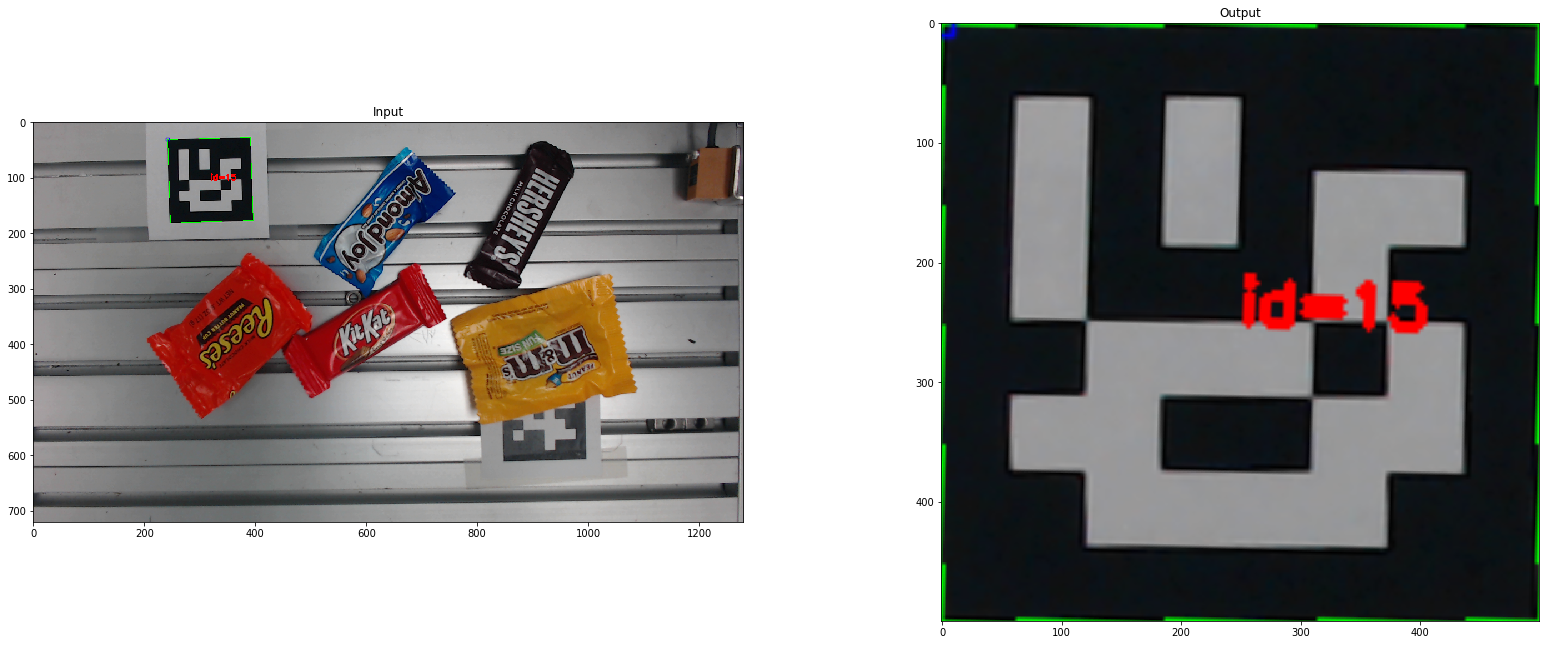

[[ 3.35270451e+00 -1.11756817e-01 -8.07890031e+02]
 [ 8.94054537e-02  3.33035315e+00 -1.24877068e+02]
 [ 5.63785130e-18  1.30104261e-18  1.00000000e+00]]


In [19]:
%matplotlib inline
from pick2d import calibratePicture, savePicFromCam
_ = savePicFromCam('cv_test.png', cam_id=0, width=1280, height=720)
pix2CartMat = calibratePicture('cv_test.png', mark_id=15, mark_size=500)
print(pix2CartMat)

## 17. Compute Base transformation Matrix for MiniBOT
We use aruco marker to define workspace coordination. Use three points to compute base transformation matrix. 
The positions we used are:
* 1. the upper left corner as origin of new workspace cooridnation.
* 2. the upper right corner as x-direction of new workspace coordination.
* 3. the lower left corner as y-direction of new workspace coordination.  

We record points `0`, `1` and `6` in `nmc.pnt_list`.

In [20]:
# First, use nexmotion API to compute transformation pose. 
coordTrans = [0.]*6
nmc.baseCalib_3p(nmc.pnt_list[0][6:], nmc.pnt_list[1][6:], nmc.pnt_list[6][6:], coordTrans)
print coordTrans

[412.60812439296734, 125.50315504599551, 303.8667055088699, -89.07524637777865, 0.9359265832610972, -178.94841512920434]


### 17.1 Get Transformation matrix

In [21]:
wk2RobMat = nm.pose2matrix(coordTrans)
print np.around(wk2RobMat, decimals=2)

[[ 2.0000e-02 -1.0000e+00  2.0000e-02  4.1261e+02]
 [-1.0000e+00 -2.0000e-02  2.0000e-02  1.2550e+02]
 [-2.0000e-02 -2.0000e-02 -1.0000e+00  3.0387e+02]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]


## 18. Write Script that will be use to pick candy
Using points that we record in `Step 11` cell to write a script to pick up candy. Note: the position for picking will need to update after inference. In next cell, we wrap the script as a functions that can be called in the whole demo flow.  
If you need to run scrtip step-by-step, you could set `is_debug = true` in `pickWithPosition` to run the script in debugger mode.

In [22]:
#TODO: Only use move cmd, not group command in script (group will not block)
from IPython.core.debugger import set_trace
from copy import deepcopy

def pickWithPosition(x_pos, y_pos, is_debug=False):
    if is_debug:
        set_trace()
    org_pnt = deepcopy(nmc.pnt_list[4])
    nmc.movePTP(2)   # camera point
    nmc.movePTP(3)   # stand_by point
    # update x,y position of pre-pick point.
    # note: pnt_list : [joints , cartesian]
    nmc.pnt_list[4][6]=x_pos
    nmc.pnt_list[4][7]=y_pos
    nmc.moveLine(4)  # pre-pick point
    
    # move down to pick the candy
    nmc.pnt_list[4][8] -= 32  
    nmc.moveLine(4)  
    nmc.writeOutputMemory([[3],[]]) # turn on suction cup
    
    # move up to pre-pick point
    nmc.pnt_list[4][8] += 32  
    nmc.moveLine(4)  
    nmc.moveLine(5)  # move to drop-off point
    nmc.writeOutputMemory([[],[]]) # turn off suction cup to drop candy
    nmc.movePTP(2)  # back to camera point.
    nmc.pnt_list[4] = org_pnt # copy original local back for pre-pick point


### 18.1 Testing script Step by Step.

In [ ]:
#pickWithPosition(300, 0, True)

## 19. Main loop for picking candy
* Given the candy you want. choose from `Kikat, Hershey, M&M, Reese, Almond Joy`.
* Get image from camera (using webcam now)
* Send to SageMaker for inference and drawing predicted image
* The center pixel position of bounding box
* Transfer to cartesian position with respect to robot base.
* Run the script to pick up candy.

In [23]:
from pick2d import *

def pick_candy(candy='Kitkat', use_picture=True, file_name='cv_test.png'):
    global target_candy, target_pose
    target_candy = candy #"M&M"
    filename = file_name #'cv_test.png'
    use_pic = use_picture #True

    if use_pic:
        frame = cv2.imread(filename)
    else: # use cam
        frame = savePicFromCam(filename, 0, 1280, 720)

    predictions = do_inference(sagemaker_client, endpoint_name, frame, 0.5)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Draw predicted image
    make_predicted_image(img, predictions, candy_list)
    
    # find the bbox info of target_candy
    confident = 0.
    imh, imw, _ = img.shape
    xmin, ymin, xman, ymax = 0,0,0,0
    for box in predictions:
        if int(box[0]) == candy_dict[target_candy] and box[1] > confident:
            confident = box[1]
            xmin = box[2] * imw
            ymin = box[3] * imh
            xmax = box[4] * imw
            ymax = box[5] * imh
            print candy_list[int(box[0])]
            print 'h-center, v-center: {:.2f}, {:.2f}'.format( (xmin + xmax)/2, (ymin+ymax)/2 )
    if confident == 0:
        print "Not detect the candy you want :(\n Please try again!"
        return [0, 0] # return dummy 2d position.
    # Transfer pixel position to marker-base cartesian position
    cen_x = (xmin + xmax)/2
    cen_y = (ymin + ymax)/2
    cen_point =  np.array([[cen_x, cen_y, 1]])
    wk_point = pix2CartMat.dot(cen_point.transpose())/10 # because 1 pixel to 0.1 mm, divede by 10
    wk_point3d = np.append(wk_point, [[1.]], axis=0)
    rb_point = wk2RobMat.dot(wk_point3d)
    target_pose =[i for i in rb_point.flat]
    return target_pose

In [24]:
%matplotlib inline

title = widgets.HTML("<h1>Happy Holiday!</h1><p> <h3>Please pick the candy you like :) </h3><p>")
display(title)

@interact_manual # Note: interact mode currently work in Notebook, Not Lab
def run_interact(interact_func=fixed(pick_candy), candy=['Kitkat', 'Hershey', 'M&M', 'Reese', 'Almond Joy'], 
                 use_picture=False, file_name=fixed('cv_test.png')):
    return interact_func(candy, use_picture, file_name)

HTML(value=u'<h1>Happy Holiday!</h1><p> <h3>Please pick the candy you like :) </h3><p>')

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2FuZHknLCBvcHRpb25zPSgnS2l0a2F0JywgJ0hlcnNoZXknLCAnTSZNJywgJ1JlZXNlJywgJ0FsbW9uZCBKb3nigKY=


In [26]:
px,py = widgets.FloatText(value=target_pose[0]), widgets.FloatText(value=target_pose[1])
@interact
def run_script(script_func=fixed(pickWithPosition), x_pos=px, y_pos=py, is_debug=fixed(False)):
    script_func(x_pos, y_pos, is_debug)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0VGV4dCh2YWx1ZT0yOTcuNjU3MzA0NTM5NzgxMywgZGVzY3JpcHRpb249dSd4X3BvcycpLCBGbG9hdFRleHQodmFsdWU9Ni43OTQ2NTAyNzE1OTfigKY=


### 20. Disable all axes of group (Servo Off)
MiniBot will make a sound when it is disabled.

In [29]:
nmc.groupDisable()

0

### 21. Shutdown device

In [30]:
nmc.deviceShutdown()

0

### Optional. Do homing for MiniBOT
It is recommand to use `NexMotion Studio` to do homing. 

In [ ]:
#nmc.groupAxesHomeDrive([])

### Option. Stop/Hold MiniBOT
You could use below commmand to stop/hold MiniBOT. But, if emergency, please use `Emergency stop button` to stop MiniBOT

In [ ]:
nmc.groupHalt()

### Option. Hide the source code from cells.
Reference:  
https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer/28073228#28073228

In [31]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')